### Talking data
[Real competition](https://www.kaggle.com/c/talkingdata-mobile-user-demographics) to build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.basemap import Basemap
from IPython.display import display, HTML, clear_output
%matplotlib inline

In [2]:
%%bash
ls data

app_events.csv
app_labels.csv
events.csv
gender_age_test.csv
gender_age_train.csv
label_categories.csv
phone_brand_device_model.csv
sample_submission.csv


In [3]:
df_app_events               = pd.DataFrame.from_csv("data/app_events.csv")
df_app_labels               = pd.DataFrame.from_csv("data/app_labels.csv")
df_events                   = pd.DataFrame.from_csv("data/events.csv")
df_gender_age_train         = pd.DataFrame.from_csv("data/gender_age_train.csv")
df_label_categories         = pd.DataFrame.from_csv("data/label_categories.csv")
df_phone_brand_device_model = pd.DataFrame.from_csv("data/phone_brand_device_model.csv")

df_gender_age_test          = pd.DataFrame.from_csv("data/gender_age_test.csv")

In [4]:
def show(df):
    print df.shape
    return df.head(3)

## Investigating data

In [5]:
show(df_app_events)

(32473067, 3)


,app_id,is_installed,is_active
event_id,,,
2,5927333115845830913,1,1
2,-5720078949152207372,1,0
2,-1633887856876571208,1,0


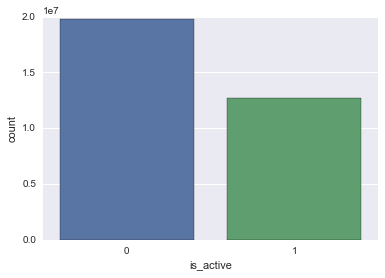

In [6]:
plot_ = sns.countplot(x="is_active", data=df_app_events)

In [7]:
df_app_events.drop(['is_installed'], axis=1, inplace=True)

### app_events

**is_active** field is approximately balanced $0$ is only $1.5$ times higher than $1$. [Discussion about is_active](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22362/is-installed-and-is-active-columns)

**is_installed** is always $1$, so I can just get rid of it. 

This table is also very huge $32M$.

-------

In [8]:
show(df_app_labels)

(459943, 1)


,label_id
app_id,
7324884708820027918,251
-4494216993218550286,251
6058196446775239644,406


507


[[]]

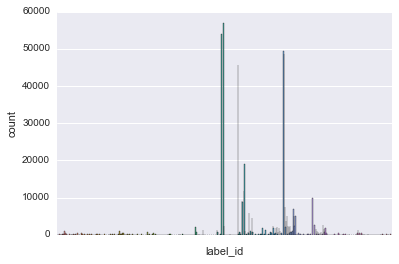

In [9]:
print df_app_labels['label_id'].nunique()
plot_ = sns.countplot(x="label_id", data=df_app_labels)
plot_.set(xticklabels=[])

In [10]:
df_app_labels['label_id'].value_counts()[:10]

548    56902
405    53936
794    49320
795    48707
704    45697
714    19083
713    11840
854     9955
710     9027
711     8831
Name: label_id, dtype: int64

`label_id` has a clear long tail distribution. Only few are very frequent, other are almost irrelevant.

### app_labels

Just connecting table. $0.5M$ entries which tag application with its label. Label will tag to some description of an application. [Most of the applications belong to many categories](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22402/app-id-and-category/128443#post128443)

There are $~500$ unique types of application

-----

In [11]:
show(df_label_categories)

(930, 1)


,category
label_id,
1,NaN
2,game-game type
3,game-Game themes


In [12]:
list(df_label_categories['category'].sample(10))

['Personal Effectiveness 1',
 'game-Horizontal version',
 'Trendy / cool',
 'payment 3',
 'Experience / DIY',
 'Convenience Store',
 'Smart bracelet',
 'Buy',
 'football',
 'Sports']

Most frequent categories of labels

In [13]:
most_frequent_labels = df_app_labels['label_id'].value_counts()[:10].index.tolist()
df_label_categories.loc[most_frequent_labels]

,category
label_id,
548,Industry tag
405,Custom label
794,Tencent
795,game
704,Property Industry 2.0
714,1 free
713,Services 1
854,Property Industry new
710,Relatives 1


### label_categories

Strangly, there are more types than I saw in `app_labals`. Also it looks like a lot of them can be grouped together. Category name is just a text and it looks like it can be parsed to automatically group stuff. **The type of an application will most probably be a very good predictor of gender and may be even age**. Will need to spend a lot of time (may be even manually) to investigate each category.

-----

In [14]:
df_events = df_events[['device_id', 'timestamp', 'latitude', 'longitude']]
show(df_events)

(3252950, 4)


,device_id,timestamp,latitude,longitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,31.24,121.38
2,-6401643145415154744,2016-05-01 00:54:12,30.97,103.65
3,-4833982096941402721,2016-05-01 00:08:05,29.70,106.60


### events

Changes lat/lng to be able to copypaste coordinates in google maps. Have some doubts about a **timestamp** field. I think it is useless. **Lat/lng** is 2 digit after the dot precision. [This is enough to have](http://gis.stackexchange.com/a/8674/9972)

> The second decimal place is worth up to 1.1 km: it can separate one village from the next.

Most probably will be able to transform 2 fields into city (country is always the same). [Some of the lat/lng values are 0](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22405/user-s-location-unique-device-id-inquiry)

---- 

In [15]:
show(df_phone_brand_device_model)

(187245, 2)


,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4


In [16]:
print df_phone_brand_device_model['phone_brand'].nunique()
print df_phone_brand_device_model['device_model'].nunique()

131
1599


### phone_brand_device_model
Just tells what kind of phone a person uses. Can be a good predictor. Most probably will need to aggregate into other uber categories and create a few things like status of the phone, price and so on. Also have to rename these Chinese stuff.

---- 

In [17]:
show(df_gender_age_train)

(74645, 3)


,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38


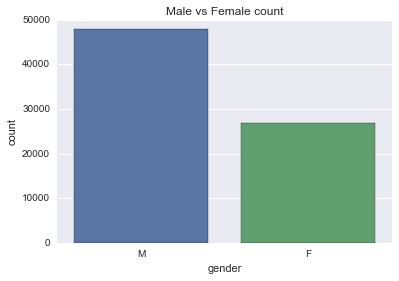

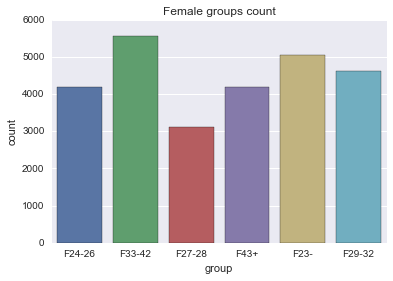

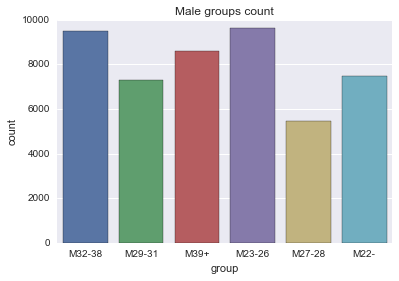

In [18]:
def gender_plot_helper(data, col, title):
    sns.countplot(x=col, data=data)
    sns.plt.title(title)
    plt.show()
    
gender_plot_helper(df_gender_age_train, "gender", "Male vs Female count")
gender_plot_helper(df_gender_age_train[df_gender_age_train['gender'] == "F"], "group", "Female groups count")
gender_plot_helper(df_gender_age_train[df_gender_age_train['gender'] == "M"], "group", "Male groups count")

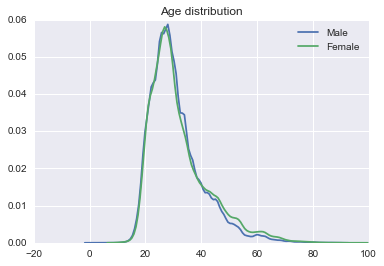

In [19]:
sns.kdeplot(df_gender_age_train.age[df_gender_age_train['gender'] == "M"], label="Male")
sns.kdeplot(df_gender_age_train.age[df_gender_age_train['gender'] == "F"], label="Female")
plt.legend()
plt.title('Age distribution')
plt.show()

### gender_age_train
The main table which will be used for testing. Not a lot of data. Only $~75k$. Females are twice as frequent. Each class is roughly the same.

----

## Takeaway after this step.

Looks very promissing:
 - **label_categories/category** find how to group them to reduce $930$ to something like $20$
 - **events** is timeseries data. Find information that I can extract. How often the person is there, how consistent, etc. Remove timestamp after that.
 - **events/latitude-longitude** Gives us 1km precision. Can be used to locate a city. Remove after that.
 - **phone_brand_device_model/phone_brand - device_model** translate into English, decrease from $131$ to like $20$. Can extract price, status of the phone
 
### Time to read the forum
 
Helpfull discussions:
 - https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22410/best-single-model
 - [only 23309 samples having app events in 74645 training samples](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22181/only-23309-samples-having-app-events-in-74645-training-samples)
 - [app events dataset](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22210/understanding-app-events-dataset)
 - [rapidly changing location](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22204/valid-location-data)
 - [Geography of China](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22191/external-data-geography-of-china)
 - [brand and name](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22270/do-brand-and-phone-names-really-matter) and [here](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22186/chinese-brands)
 - [predict age and gender separately](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22367/predicting-age-and-gender-separately)
 - [log loss](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22269/python-code-for-evalulating-score) and [here](https://www.kaggle.com/zeroblue/talkingdata-mobile-user-demographics/better-log-loss-function/comments)

### Reading scripts

Model:
 - [XGB](https://www.kaggle.com/kumareshd/talkingdata-mobile-user-demographics/chicken-momos-plate-1/run/299504/code) [another one](https://www.kaggle.com/tilii7/talkingdata-mobile-user-demographics/xgboost-simple-starter-more-features/code) another [one](https://www.kaggle.com/zfturbo/talkingdata-mobile-user-demographics/xgboost-simple-starter/code) [XGBoost 2.389](https://www.kaggle.com/sglink/talkingdata-mobile-user-demographics/xgboost-simple-starter/run/294382/code)
 - [optimizing parameters](https://www.kaggle.com/tilii7/talkingdata-mobile-user-demographics/bayesian-optimization-xgboost-parameters/comments)
 - [bag of apps](https://www.kaggle.com/hulkbulk/talkingdata-mobile-user-demographics/low-ram-bag-of-apps-python-2-7)
and [here](https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/low-ram-bag-of-apps-python) and [here](https://www.kaggle.com/xiaoml/talkingdata-mobile-user-demographics/bag-of-app-id-python-2-27392)
 - [apps labels linear](https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/a-linear-model-on-apps-and-labels)
 - [brand and model](https://www.kaggle.com/dvasyukova/talkingdata-mobile-user-demographics/brand-and-model-based-benchmarks/comments) and [here](https://www.kaggle.com/autoptr/talkingdata-mobile-user-demographics/learning-pandas-follow-by-experts-i/run/310854/notebook)
 - [look at the script](https://www.kaggle.com/munitech4u/talkingdata-mobile-user-demographics/first-trial/run/302356)
 - https://www.kaggle.com/anokas/talkingdata-mobile-user-demographics/beat-the-benchmark-2-42107/discussion
 

Preprocessing:

- [combine all tables into one](https://www.kaggle.com/tunguz/talkingdata-mobile-user-demographics/the-one-table) and [here](https://www.kaggle.com/arjoonn/talkingdata-mobile-user-demographics/the-one-table)
- [phone brands](https://www.kaggle.com/rohansadale/talkingdata-mobile-user-demographics/more-enhancement-on-phonebrands-file) and [here](https://www.kaggle.com/iuga77/talkingdata-mobile-user-demographics/translate-brand-names-snippet/code) [brand names](https://www.kaggle.com/adhirb/talkingdata-mobile-user-demographics/translate-brand-names-and-fill-missing/discussion)
- [labels](https://www.kaggle.com/nickdudaev/talkingdata-mobile-user-demographics/categorizing-labels/notebook)

Visualization:

- [geolocation visualization](https://www.kaggle.com/beyondbeneath/talkingdata-mobile-user-demographics/geolocation-visualisations/notebook) **investigated**
- [geolocation heatmap](https://www.kaggle.com/beyondbeneath/talkingdata-mobile-user-demographics/geolocation-heatmap) **investigated**
- [gender](https://www.kaggle.com/klepacz/talkingdata-mobile-user-demographics/firsttry) **not interesting**
- [age gender](https://www.kaggle.com/dollardollar/talkingdata-mobile-user-demographics/app-usage-by-age-and-gender) **not interesting**
- [user demographic](https://www.kaggle.com/the1owl/talkingdata-mobile-user-demographics/can-you-hear-me-now/comments) **not interesting**
- [exploration](https://www.kaggle.com/andreburk/talkingdata-mobile-user-demographics/some-exploration) **interesting**
- [time and day gender](https://www.kaggle.com/russwilliams/talkingdata-mobile-user-demographics/investigating-time-and-day-and-gender) [continuation](https://www.kaggle.com/russwilliams/talkingdata-mobile-user-demographics/who-s-active-on-friday-night) **investigated, shows that time and day is a good predictor**
- [exploration](https://www.kaggle.com/shadimoodad/talkingdata-mobile-user-demographics/talkingdata-exploration) **nothing interesting**
- [timezone investigation](https://www.kaggle.com/russwilliams/talkingdata-mobile-user-demographics/time-zones) **nothing interesting except of he claims that time is in Chinese Standard Time**
- [animation](https://www.kaggle.com/maddarwin/talkingdata-mobile-user-demographics/one-day-in-china-geolocation-animation/run/306864/code) **interesting, but useless**
- [map of events](https://www.kaggle.com/ramirogomez/talkingdata-mobile-user-demographics/talkingdata-event-locations-map/notebook) **bad**
- [heatmap](https://www.kaggle.com/ryanzhang/talkingdata-mobile-user-demographics/heatmap-of-event-times-for-a-device/comments) **investigated**

- [R map of events](https://www.kaggle.com/flora0420/talkingdata-mobile-user-demographics/improved-visualization-of-events-in-r)
- [R exploration](https://www.kaggle.com/amhchiu/talkingdata-mobile-user-demographics/playing-around-wip) and [here](https://www.kaggle.com/mmrosenb/talkingdata-mobile-user-demographics/talkingdata-eda) and [here](https://www.kaggle.com/chechir/talkingdata-mobile-user-demographics/only-another-exploratory-analysis) and [here](https://www.kaggle.com/tonyliu/talkingdata-mobile-user-demographics/the-battle-of-smart-phones) **last one is interesting**
--- 
## Visualization

-----

#### Investigating geolocation data.

[inspired by this post](https://www.kaggle.com/beyondbeneath/talkingdata-mobile-user-demographics/geolocation-visualisations/comments).

In [20]:
def show_events(basemap_instance, lng_list, lat_list, title):
    plt.figure(figsize=(20, 10))
    
    basemap_instance.fillcontinents(color='#404040', lake_color='#000000')
    basemap_instance.drawmapboundary(fill_color='#000000')
    basemap_instance.drawcountries(linewidth=0.3, color="w")

    mxy = basemap_instance(lng_list, lat_list,)
    basemap_instance.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

    plt.title(title)
    plt.show()

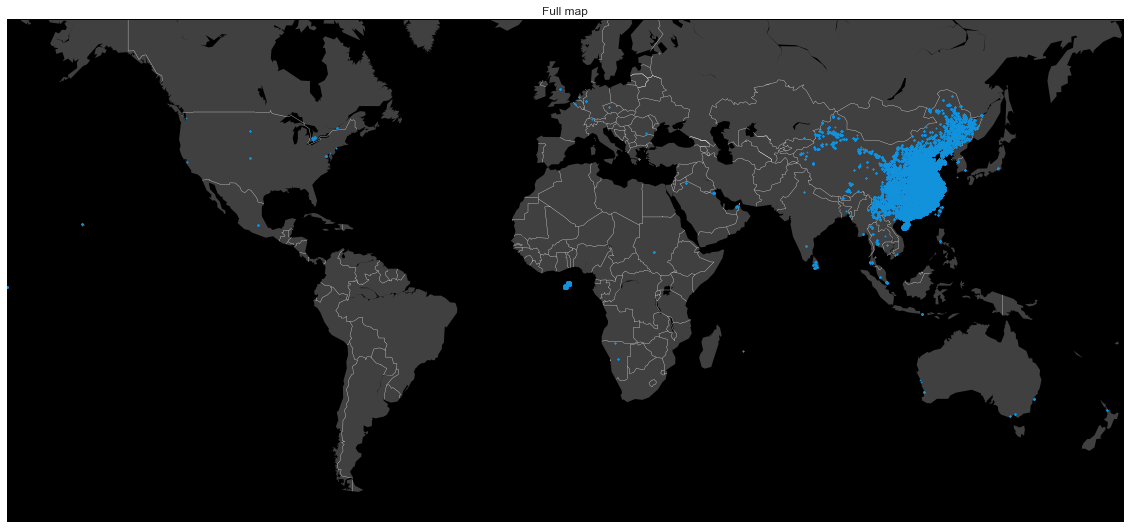

In [21]:
base_map = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=65, llcrnrlon=-180, urcrnrlon=180)
show_events(base_map, df_events["longitude"].tolist(), df_events["latitude"].tolist(), "Full map")

Majority of the events are from China. There are also many events close to (0, 0) coordinate which is most probably undefined events. Now zooming in to China.

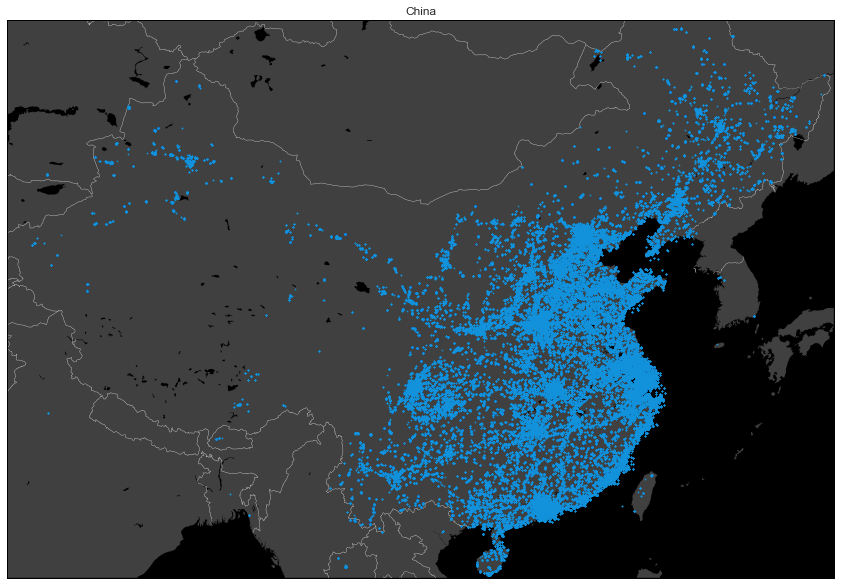

In [22]:
# would be better to exclude irrelevant points
lon_min, lon_max, lat_min, lat_max = 74, 135, 18, 51
idx_china = (df_events["longitude"] > lon_min) & (df_events["longitude"] < lon_max) & (df_events["latitude"] > lat_min) & (df_events["latitude"] < lat_max)
df_events_china = df_events[idx_china]

base_map = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=35, resolution='i')
show_events(base_map, df_events_china["longitude"].tolist(), df_events_china["latitude"].tolist(), "China")

The data [resembles population density in China](http://www.china-food-security.org/images/maps/pop/pop_2_h.jpg). Now Let's look at the male/female distribution.

In [23]:
tmp = pd.merge(
    df_gender_age_train.reset_index(),
    df_events_china, on="device_id", how="inner"
)[['gender', 'age', 'group', 'latitude', 'longitude']]
plot_m = tmp[tmp['gender'] == 'M']
plot_f = tmp[tmp['gender'] == 'F']

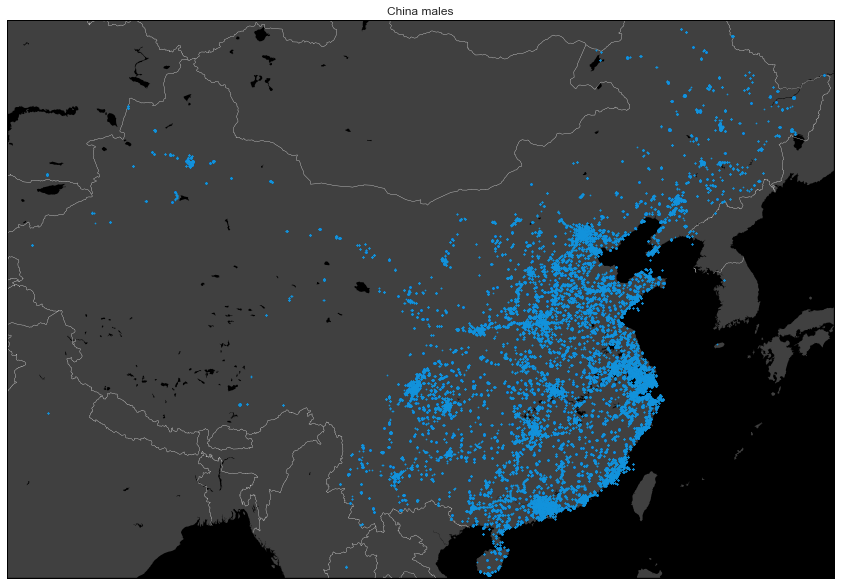

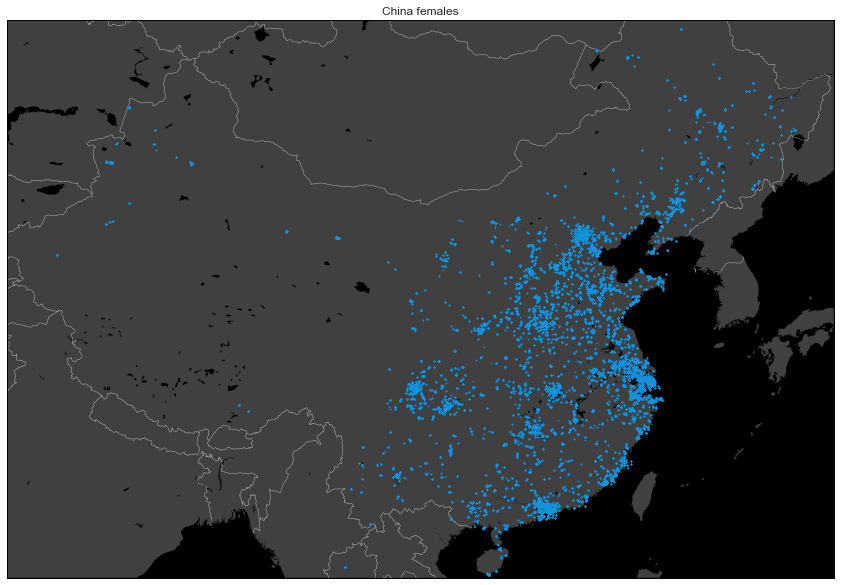

In [24]:
show_events(base_map, plot_m['longitude'].tolist(), plot_m['latitude'].tolist(), "China males")
show_events(base_map, plot_f['longitude'].tolist(), plot_f['latitude'].tolist(), "China females")

The plots look different, but important question whether they look different because of the number of males is 1.5 times bigger of because of some pattern. This should be investigated. 

[Example with a very nice gaussian filters is here](https://www.kaggle.com/beyondbeneath/talkingdata-mobile-user-demographics/geolocation-heatmap)

### Investigating timestamp data 

[Inspired by this post](https://www.kaggle.com/ryanzhang/talkingdata-mobile-user-demographics/heatmap-of-event-times-for-a-device/comments)

In [25]:
from datetime import datetime
def get_day(dt):
    return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').weekday()

def get_hour(dt):
    return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour

In [26]:
df_events['day_of_week'] = df_events['timestamp'].apply(get_day)
df_events['hour']        = df_events['timestamp'].apply(get_hour)

Count the number of events that appeared at each day of week/hour

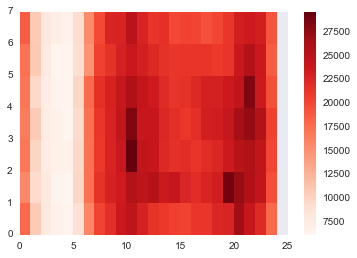

In [27]:
time_info = df_events[['day_of_week', 'hour', 'device_id']].groupby(['day_of_week', 'hour']).count()
time_info_unstack = time_info.unstack()

plt.pcolor(time_info_unstack, cmap='Reds')
plt.colorbar()
plt.show()

In [28]:
print("Total # events:", len(df_events))
print("Total # Beijing events:", len(df_events_china))

('Total # events:', 3252950)
('Total # Beijing events:', 2202430)


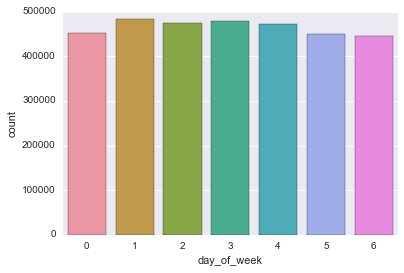

In [29]:
plot_ = sns.countplot(x="day_of_week", data=df_events)

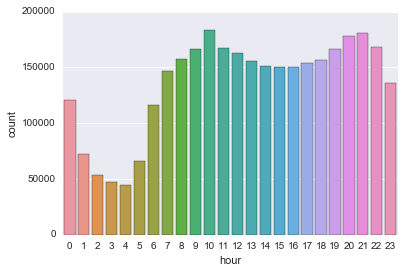

In [30]:
plot_ = sns.countplot(x="hour", data=df_events)

There is almost no difference in day of week count. But for the hours, there is a clear low count from 2 to 4. Let's check how the graph looks like if I will just aggregate on day + hour.

[[]]

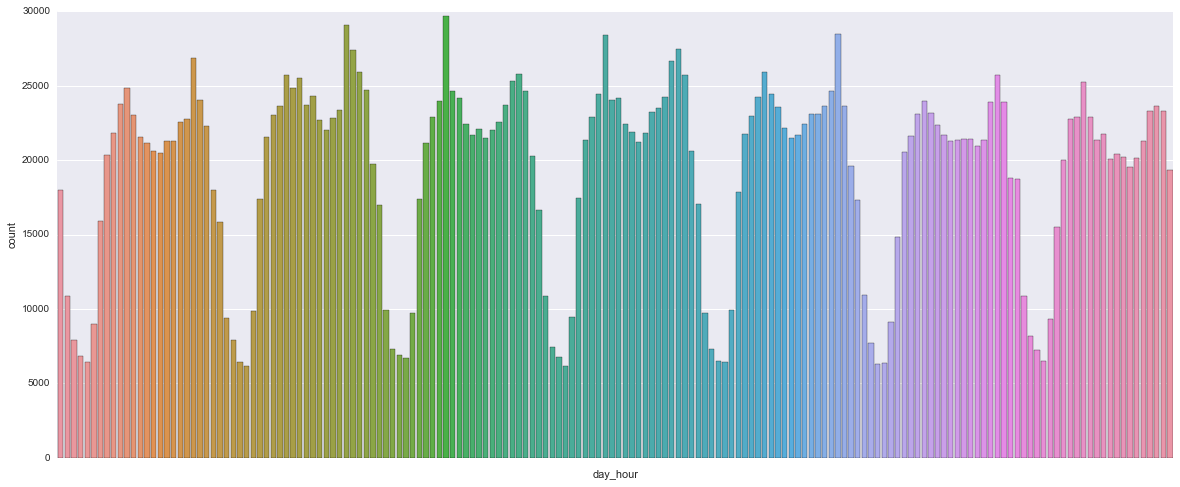

In [32]:
df_events['day_hour'] = df_events['day_of_week'] * 24 + df_events['hour']

plt.figure(figsize=(20, 8))
plot_ = sns.countplot(x="day_hour", data=df_events)
plot_.set(xticklabels=[])

Here I am done with exploration and will continue further with data preparation